# Crop the 3D Volume based on some points

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
## To find out the suitable crop size.
## based on ROI points
import Functions.MyDataset as MyDataset
import importlib

importlib.reload(MyDataset)

name_list, pts = MyDataset.load_data_dir("/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_data/")

In [ ]:
max_diff_x = 0
max_diff_y = 0
max_diff_z = 0

for patient in range(pts.shape[0]):
    diff_x = max([abs(pts[patient, 0, 0]-pts[patient, 1, 0]), abs(pts[patient, 0, 0]-pts[patient, 2, 0]),
                  abs(pts[patient, 0, 0]-pts[patient, 3, 0])])
    max_diff_x = max([max_diff_x, diff_x])
    diff_y = max([abs(pts[patient, 0, 1]-pts[patient, 1, 1]), abs(pts[patient, 0, 1]-pts[patient, 2, 1]),
                  abs(pts[patient, 0, 1]-pts[patient, 3, 1])])
    max_diff_y = max([max_diff_y, diff_y])
    diff_z = max([abs(pts[patient, 0, 2]-pts[patient, 1, 2]), abs(pts[patient, 0, 2]-pts[patient, 2, 2]),
                  abs(pts[patient, 0, 2]-pts[patient, 3, 2])])
    max_diff_z = max([max_diff_z, diff_z])

In [ ]:
print("max_diff_x: ", max_diff_x)
print("max_diff_y: ", max_diff_y)
print("max_diff_z: ", max_diff_z)

## Looks like the area is still too big (598, 188, 169)
So, we think we can focus on the left and right landmark area separately

In [ ]:
## Check the cropped results
import numpy as np
import importlib
import Functions.MyDataset as MyDataset
import Functions.Visualization as Visualization

pat_aug_path = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_data/AH_aug_15.mat"

pixel_space = [0.15, 0.15, 0.15]

importlib.reload(Visualization)

pat_aug_volume, pat_aug_pts, _ = MyDataset.load_mat_data(pat_aug_path)

print(pat_aug_pts)

Visualization.show_pts(pat_aug_volume, pat_aug_pts, pixel_space)

print(pat_aug_pts)

In [ ]:
import Functions.MyCrop as MyCrop

crop_s = ((50, 50), (50, 50), (50, 50))
left_volume, left_points, left_length, right_volume, right_points, right_length = MyCrop.crop_volume(pat_aug_volume, pat_aug_pts, crop_s)
flip_right_volume, flip_right_points = MyCrop.flip_volume(right_volume, right_points)

In [ ]:
print("Original Points: ", pat_aug_pts)
print("Locate back: ", np.append(left_points + left_length, right_points + right_length, axis=0))

In [ ]:
importlib.reload(Visualization)
import time
from IPython.display import display, clear_output

pixel_space = [0.15, 0.15, 0.15]

Visualization.show_two_landmarks(left_volume, left_points, flip_right_volume, flip_right_points, pixel_space)

# for i in range(100):
#     left_points[0][2] = i
#     left_points[1][2] = i
#     flip_right_points[0][2] = i
#     flip_right_points[1][2] = i
#     Visualization.show_two_landmarks(left_volume, left_points, flip_right_volume, flip_right_points, pixel_space)
#     time.sleep(1)
#     clear_output(wait=True)

## Crop the augmented volumes

In [91]:
import numpy as np
import Functions.MyDataset as MyDataset

# store cropped volumes into one arrays, and points to another
pixel_space = [0.15, 0.15, 0.15]
# for Windows
# dir_path = "F:/Data/original_augmentation_data/"
# save_volumes_dir = "F:/Data/cropped/x5050y5050z5050/volumes/"
# save_points_dir = "F:/Data/cropped/x5050y5050z5050/points/"
# save_length_dir = "F:/Data/cropped/x5050y5050z5050/length/"
# for Mac
dir_path = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_data/"
save_volumes_dir = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/Cropped/based_on_pred/volumes/"
save_points_dir = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/Cropped/based_on_pred/points/"
save_length_dir = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/Cropped/based_on_pred/length/"
pat_names = MyDataset.get_pat_names()

In [92]:
# Prepare reading Test Dataset, and prediction centres
pat_splits = MyDataset.get_pat_splits(static=True)
pat_names_test = [pat_names[idx] for idx in pat_splits[2]] # idx: 0 train, 1 val, 2 test

In [93]:
landmarks_centres = np.load("/Volumes/Shawn_HDD/PhD/Project/Date/trained_models/bestVal_straight_model_divided_176_88_48_mean_two_landmarks_MTL_pred_org.npy")

In [ ]:
from IPython.display import display, clear_output
import importlib

import Functions.MyCrop as MyCrop
import Functions.Visualization as Visualization

importlib.reload(MyCrop)

for pat_name in pat_names_test:
    pat_id = pat_names_test.index(pat_name)
    for aug_id in range(1, 51):
        # such as: "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_data/AH_aug_1.mat"
        file_path = dir_path + pat_name + "_aug_" + str(aug_id) + ".mat"
        print("load file: ", file_path)
        aug_volume, aug_pts, _ = MyDataset.load_mat_data(file_path)
        clear_output(wait=True)
        print("crop volume for: ", file_path)
        llscc_centre_idx = pat_id * 100 + (aug_id - 1) * 2
        anchors = landmarks_centres[[llscc_centre_idx, llscc_centre_idx+1], 0, :]
        left_volume, left_points, left_length, right_volume, right_points, right_length = MyCrop.crop_volume_anchor(aug_volume, aug_pts,anchors)
        flip_right_volume, flip_right_points = MyCrop.flip_volume(right_volume, right_points)
        Visualization.show_two_landmarks(left_volume, left_points, flip_right_volume, flip_right_points, pixel_space)
        print("save the cropped volumes")
        np.save(save_volumes_dir + pat_name + "_augVolume_"+str(aug_id)+"_cropped_left.npy", left_volume)
        np.save(save_volumes_dir + pat_name + "_augVolume_"+str(aug_id)+"_cropped_right.npy", flip_right_volume)
        np.save(save_points_dir + pat_name + "_augPoints_"+str(aug_id)+"_cropped_left.npy", left_points)
        np.save(save_length_dir + pat_name + "_augLength_"+str(aug_id)+"_cropped_left.npy", left_length)
        np.save(save_points_dir + pat_name + "_augPoints_"+str(aug_id)+"_cropped_right.npy", flip_right_points)
        np.save(save_length_dir + pat_name + "_augLength_"+str(aug_id)+"_cropped_right.npy", right_length)
        print("Finish cropping: " + file_path)

In [ ]:
# Combine cropped volumes
cropped_volumes = []
cropped_points = []
cropped_length = []

for pat_name in pat_names_test:
    for aug_id in range(1, 51):
        # such as: "F:/Data/cropped/x5050y5050z5050/volumes/AH_augVolume_1_cropped_left_100x100x100.npy"
        #          "F:/Data/cropped/x5050y5050z5050/volumes/AH_augVolume_1_cropped_right_100x100x100.npy"
        #          "F:/Data/cropped/x5050y5050z5050/points/AH_augPoints_1_cropped_left_100x100x100.npy"
        #          "F:/Data/cropped/x5050y5050z5050/points/AH_augPoints_1_cropped_right_100x100x100.npy"
        print("**************" + pat_name + "__" + str(aug_id) + "***************")
        cropped_volume_left_path = save_volumes_dir + pat_name + "_augVolume_" + str(aug_id) + "_cropped_left.npy"
        cropped_volume_right_path = save_volumes_dir + pat_name + "_augVolume_" + str(aug_id) + "_cropped_right.npy"
        cropped_points_left_path = save_points_dir + pat_name + "_augPoints_" + str(aug_id) + "_cropped_left.npy"
        cropped_length_left_path = save_length_dir + pat_name + "_augLength_" + str(aug_id) + "_cropped_left.npy"
        cropped_points_right_path = save_points_dir + pat_name + "_augPoints_" + str(aug_id) + "_cropped_right.npy"
        cropped_length_right_path = save_length_dir + pat_name + "_augLength_" + str(aug_id) + "_cropped_right.npy"
        cropped_volume_left = np.load(cropped_volume_left_path)
        cropped_volume_right = np.load(cropped_volume_right_path)
        cropped_points_left = np.load(cropped_points_left_path)
        cropped_length_left = np.load(cropped_length_left_path)
        cropped_points_right = np.load(cropped_points_right_path)
        cropped_length_right = np.load(cropped_length_right_path)
        cropped_volumes.append(cropped_volume_left)
        cropped_volumes.append(cropped_volume_right)
        cropped_points.append(cropped_points_left)
        cropped_points.append(cropped_points_right)
        cropped_length.append(cropped_length_left)
        cropped_length.append(cropped_length_right)

print(len(cropped_volumes))
print(len(cropped_points))
print(len(cropped_length))

In [100]:
cropped_volumes = np.asarray(cropped_volumes).reshape((400, 100, 100, 100, 1))
cropped_points = np.asarray(cropped_points).reshape((400, 2, 3))
cropped_length = np.asarray(cropped_length).reshape((400, 2, 3))

# save_comb_dir = "F:/Data/cropped/cropped_volumes_x5050y5050z5050.npy"
save_comb_dir = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/Cropped/based_on_pred"
comb_tag = "x5050y5050z5050_pred"
np.save(f"{save_comb_dir}/cropped_volumes_{comb_tag}.npy", cropped_volumes)
np.save(f"{save_comb_dir}/cropped_points_{comb_tag}.npy", cropped_points)
np.save(f"{save_comb_dir}/cropped_length_{comb_tag}.npy", cropped_length)

In [101]:
print("cropped_volumes shape: ", cropped_volumes.shape)
print("cropped_points shape: ", cropped_points.shape)
print("cropped_length shape: ", cropped_length.shape)

cropped_volumes shape:  (400, 100, 100, 100, 1)
cropped_points shape:  (400, 2, 3)
cropped_length shape:  (400, 2, 3)


## Check the sub cropped dataset

In [89]:
import numpy as np

import Spartan.support_modules as supporter
import Functions.MyDataset as MyDataset

import importlib

importlib.reload(supporter)

base_dir = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/Cropped/based_on_truth/x7575y7575z5050_trans/s1_test_dis"
X_path = f"{base_dir}/100x100x100_static_s1testdis_X_val.npy"
Y_path = f"{base_dir}/100x100x100_static_s1testdis_Y_val.npy"
length_path = f"{base_dir}/100x100x100_static_s1testdis_length_val.npy"

X_test = np.load(X_path)
Y_test = np.load(Y_path)
length_test = np.load(length_path)

In [125]:
import Functions.MyDataset as MyDataset

crop_size = (100, 100, 100)

check_id = 16

pat_name = "DM"
pat_aug_id = int(check_id/2 + 1)

print(f"Check name:{pat_name}, aug_id:{pat_aug_id}")

aug_dir = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_data/"
pt_aug_path = aug_dir + pat_name + "_aug_" + str(pat_aug_id) + ".mat"

pixel_space = [0.15, 0.15, 0.15]

pat_aug_volume, pat_aug_pts, _ = MyDataset.load_mat_data(pt_aug_path)

Check name:DM, aug_id:9


In [121]:
import Functions.MyCrop as MyCrop

importlib.reload(MyCrop)

check_id = 16

left_volume_check = X_test[check_id,:,:,:,0]
left_landmarks_check = Y_test[check_id, :, :]
left_length_check = length_test[check_id]
right_volume_check = X_test[check_id+1,:,:,:,0]
right_landmarks_check = Y_test[check_id+1]
right_length_check = length_test[check_id+1]

right_landmarks_check_flip = MyCrop.flip_volume_shape(crop_size, right_landmarks_check)

In [122]:
print(right_landmarks_check)
print(right_landmarks_check_flip)

[[56.33629  27.756489 47.863415]
 [53.802658 53.40609  34.23701 ]]
[[44.66371  27.756489 47.863415]
 [47.197342 53.40609  34.23701 ]]


Original landmarks:  [[756.48857407 684.25428139 284.4482075 ]
 [743.65036661 704.5831427  271.45136839]
 [228.66371404 528.75648978 336.86341468]
 [231.19734529 554.40608613 323.23700943]]
Check left landmarks:  [[756.4886  684.2543  284.4482 ]
 [743.6504  704.5831  271.45135]]
Check right landmarks:  [[228.66371 528.7565  336.8634 ]
 [231.19734 554.40607 323.237  ]]


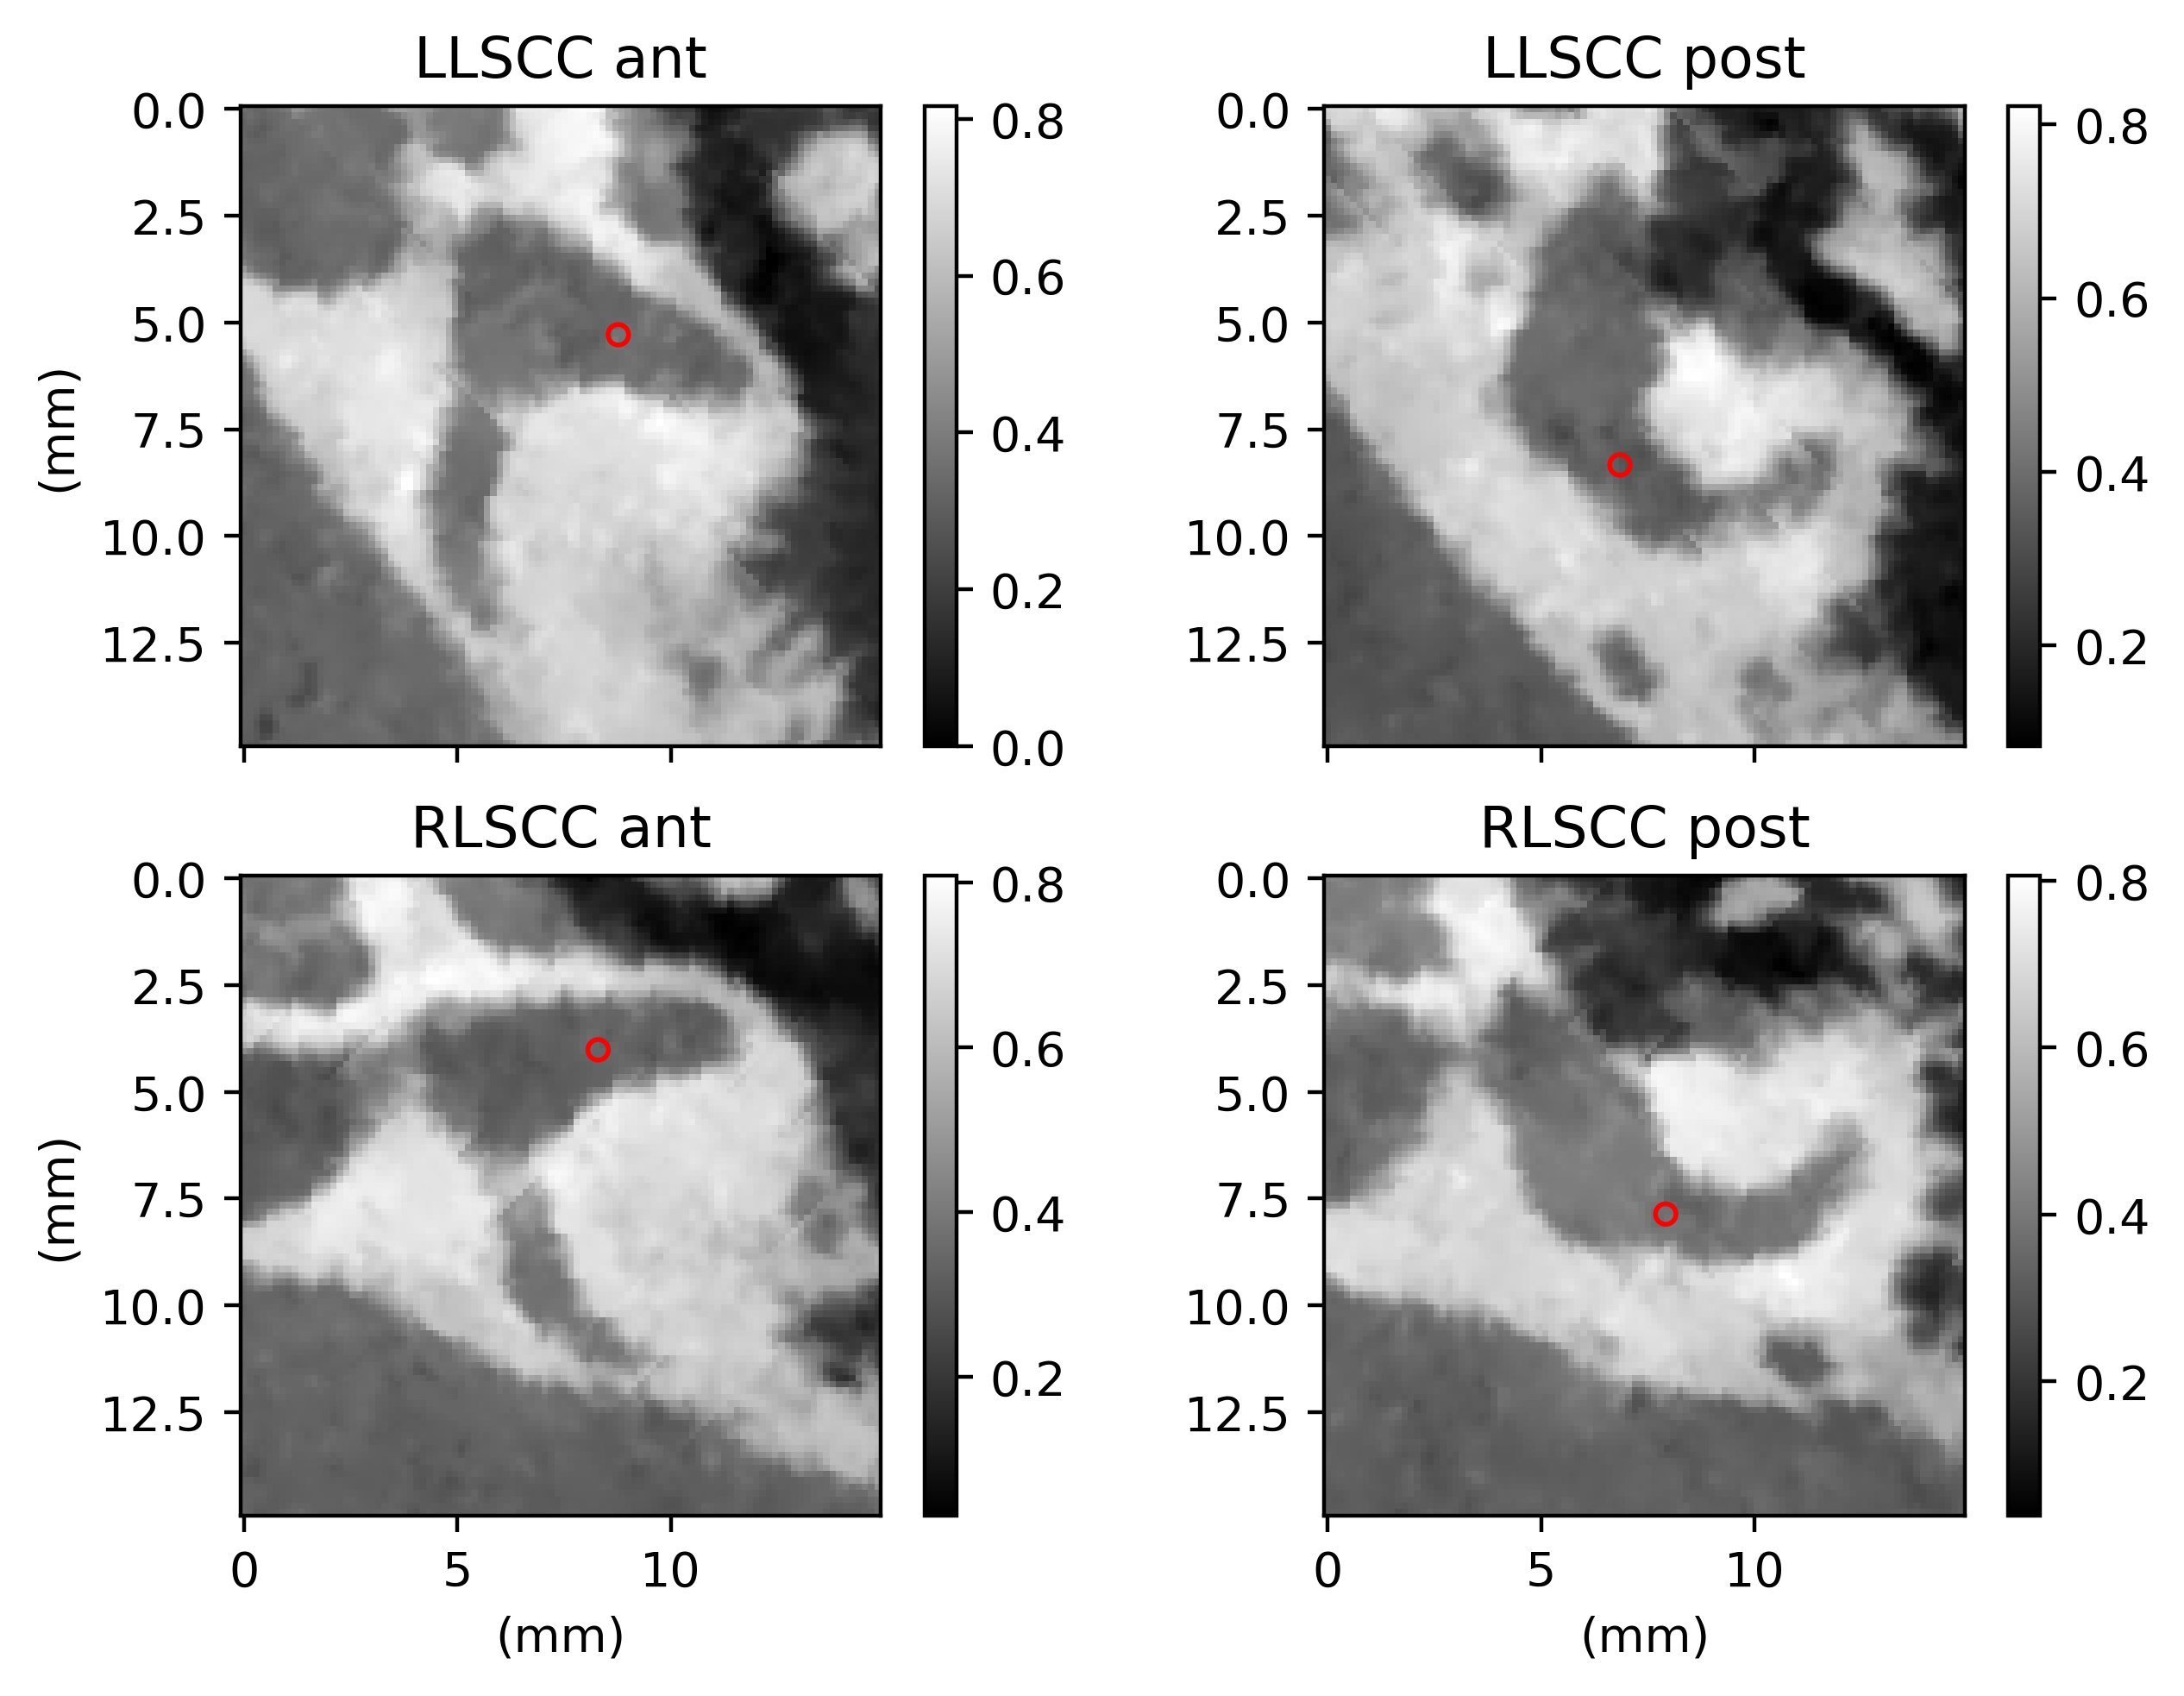

In [127]:
import Functions.Visualization as Visualization

importlib.reload(Visualization)

print("Original landmarks: ", pat_aug_pts)
print("Check left landmarks: ", left_landmarks_check + left_length_check)
print("Check right landmarks: ", right_landmarks_check_flip + right_length_check)

Visualization.show_two_landmarks(left_volume_check, left_landmarks_check, right_volume_check, right_landmarks_check, pixel_space)

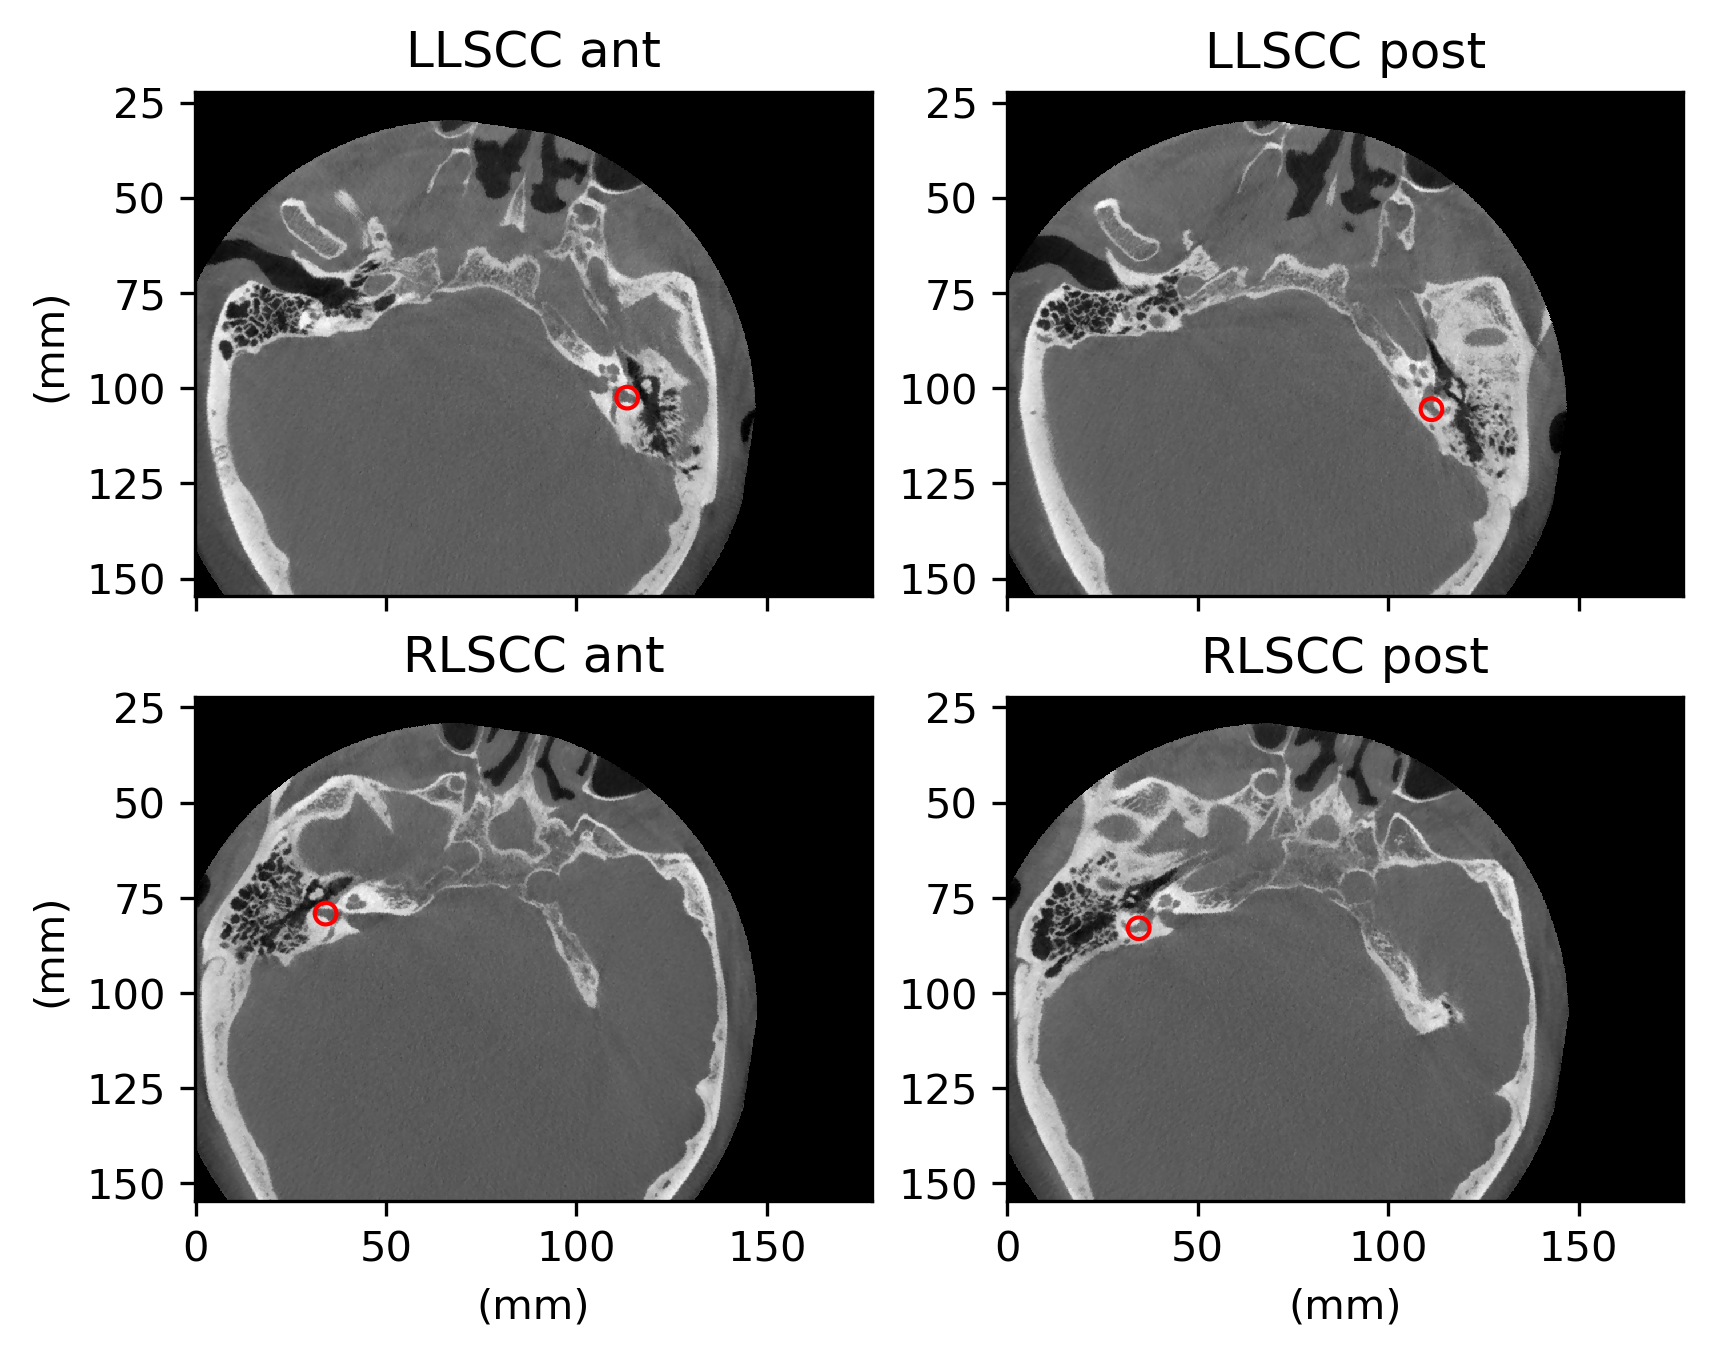

In [126]:
pixel_space= [0.15, 0.15, 0.15]

Visualization.show_pts(pat_aug_volume, pat_aug_pts, pixel_space)

## Calculate the cropped_length

In [45]:
import h5py
import numpy as np

landmarks_path = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_data/AH_aug_2.mat"
volume_size_path = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_volume_size/AH_augSize_2.mat"

landmarks_file = h5py.File(landmarks_path, 'r')
volume_size_file= h5py.File(volume_size_path, 'r')

landmarks_cropped_check = np.load("/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/Cropped/cropped_points_x5050y5050z5050.npy")

In [46]:
landmarks = np.asarray(landmarks_file.get('augPts')).reshape(3, 4).T
volume_size = np.asarray(volume_size_file.get('volumeSize'))

In [53]:
import Functions.MyCrop as MyCrop

importlib.reload(MyCrop)

left_landmarks, left_cropped_length, right_landmarks, right_cropped_length = MyCrop.crop_volume_shape(volume_size, landmarks)

right_landmarks_flipped = MyCrop.flip_volume_shape((100, 100, 100), right_landmarks)

In [54]:

left_landmarks_check = landmarks_cropped_check[2]
right_landmarks_check = landmarks_cropped_check[3]

In [56]:
print("left_landmarks cropped:", left_landmarks)
print("left_landmarks check:", left_landmarks_check)
print("right_landmarks cropped:", right_landmarks_flipped)
print("right_landmarks check:", right_landmarks_check)

left_landmarks cropped: [[51.15975662 34.59953945 50.23935345]
 [47.58622571 64.19868863 47.97655764]]
left_landmarks check: [[52.15975662 35.59953945 51.23935345]
 [48.58622571 65.19868863 48.97655764]]
right_landmarks cropped: [[57.42920872 36.96424741 52.87746313]
 [41.3167736  62.23752452 46.90662578]]
right_landmarks check: [[56.42920872 37.96424741 53.87746313]
 [40.3167736  63.23752452 47.90662578]]


In [59]:
print(landmarks)

[[786.15975662 501.59953945 226.23935345]
 [782.58622571 531.19868863 223.97655764]
 [277.57079128 586.96424741 225.87746313]
 [293.6832264  612.23752452 219.90662578]]


In [67]:
print(left_landmarks_check+left_cropped_length-1)

right_landmarks_check_flipped = MyCrop.flip_volume_shape((100, 100, 100), right_landmarks_check)
print(right_landmarks_check_flipped+right_cropped_length-1)

[[786.15975662 501.59953945 226.23935345]
 [782.58622571 531.19868863 223.97655764]]
[[277.57079128 586.96424741 225.87746313]
 [293.6832264  612.23752452 219.90662578]]


In [71]:
aug_dir = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_data/"
size_dir = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_volume_size/"

pat_names = MyDataset.get_pat_names()

cropped_length = None
for pat_name in pat_names:
    for aug_id in range(1, 51):
        aug_file_path = f"{aug_dir}{pat_name}_aug_{aug_id}.mat"
        size_file_path = f"{size_dir}{pat_name}_augSize_{aug_id}.mat"
        aug_file = h5py.File(aug_file_path, 'r')
        size_file = h5py.File(size_file_path, 'r')
        landmarks = np.asarray(aug_file.get('augPts')).reshape(3, 4).T
        volume_size = np.asarray(size_file.get('volumeSize'))
        left_landmarks, left_cropped_length, right_landmarks, right_cropped_length = \
            MyCrop.crop_volume_shape(volume_size, landmarks)
        c_length = np.concatenate((left_cropped_length, right_cropped_length), axis=0)
        # combine the cropped length
        if cropped_length is None:
            cropped_length = c_length
        else:
            cropped_length = np.concatenate((cropped_length, c_length), axis=0)


In [72]:
cropped_length = cropped_length.reshape((2000, 2, 3))

In [76]:
print(left_landmarks_check+cropped_length[2]-1)

right_landmarks_check_flipped = MyCrop.flip_volume_shape((100, 100, 100), right_landmarks_check)
print(right_landmarks_check_flipped+cropped_length[3]-1)

[[786.15975662 501.59953945 226.23935345]
 [782.58622571 531.19868863 223.97655764]]
[[277.57079128 586.96424741 225.87746313]
 [293.6832264  612.23752452 219.90662578]]


In [79]:
np.save("/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/Cropped/cropped_length_x5050y5050z5050.npy", cropped_length)

In [5]:
import numpy as np

length_array = np.load("/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/Cropped/based_on_truth/cropped_length_x5050y5050z5050.npy")

In [6]:
length_array[0:5]

array([[[704., 413., 156.],
        [704., 413., 156.]],

       [[199., 438., 161.],
        [199., 438., 161.]],

       [[734., 466., 175.],
        [734., 466., 175.]],

       [[235., 549., 172.],
        [235., 549., 172.]],

       [[780., 488., 290.],
        [780., 488., 290.]]])

In [3]:
length_array = length_array - 1
length_array[0:5]

array([[[704., 413., 156.],
        [704., 413., 156.]],

       [[199., 438., 161.],
        [199., 438., 161.]],

       [[734., 466., 175.],
        [734., 466., 175.]],

       [[235., 549., 172.],
        [235., 549., 172.]],

       [[780., 488., 290.],
        [780., 488., 290.]]])

In [4]:
np.save("/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/Cropped/based_on_truth/cropped_length_x5050y5050z5050.npy", length_array)